In [1]:
from funciones_helmholtz_bem import Circle_n
from funciones_helmholtz_bem import frequencyToWavenumber
from funciones_helmholtz_bem import solveExteriorBoundary
from funciones_helmholtz_bem import solveExterior
from funciones_helmholtz_bem import phi_test_problem_1_2
from funciones_helmholtz_bem import generateInteriorPoints_test_problem_2
from funciones_helmholtz_bem import plot_solutions
from funciones_helmholtz_bem import plot_edges_and_field
from funciones_helmholtz_bem import generateInteriorPoints_excluding_circle
from funciones_helmholtz_bem import sound_hard_circle_calc
from funciones_helmholtz_bem import mask_displacement
from funciones_helmholtz_bem import plot_exact_displacement
from funciones_helmholtz_bem import plot_bem_displacements
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from numpy.linalg import norm
# reload kernel
%load_ext autoreload
%autoreload 2

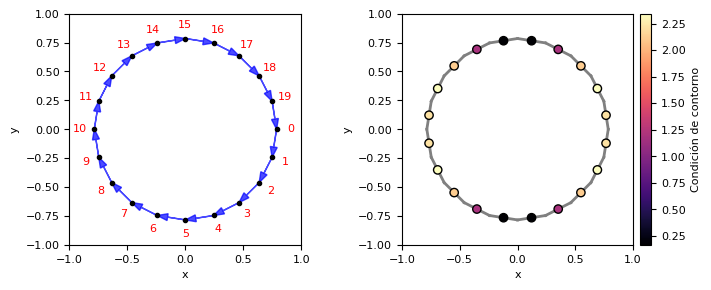

In [2]:
"""
Grafica ilistrativa de los bordes 
"""
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 20

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

# Grafica de los bordes
plot_edges_and_field(aVertex, aElement, aCenters, f)

In [58]:
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 15

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

In [4]:
def plot_edges_and_field(vertices, elementos, centros, f, integration_points=None, cmap="magma"):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'width_ratios': [1.5, 1.5]})

    # Subplot 1: Aristas orientadas con flechas
    ax = axs[0]
    colormap = plt.get_cmap(cmap)

    for i, (start, end) in enumerate(elementos):
        p1, p2 = vertices[start], vertices[end]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linewidth=2)

    # Puntos de integración (si se proporcionan)
    if integration_points is not None:
        ax.scatter(integration_points[:, 0], integration_points[:, 1], 
                   color='gray', s=10, label='Puntos de integración', alpha=0.6)

    sc = ax.scatter(centros[:, 0], centros[:, 1], c=f.real, cmap=colormap, zorder=3, label='Centros')

    #cbar = fig.colorbar(sc, ax=ax, label="Condición de contorno", orientation="vertical", pad=0.02, aspect=20, shrink=1.0)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    #ax.legend(loc='upper right', fontsize=6)

    plt.savefig("edges_and_field.svg", dpi=150, bbox_inches='tight')
    


    # Subplot 2: Campo escalar en centros
    ax = axs[1]
    colormap = plt.get_cmap(cmap)

    for i, (start, end) in enumerate(elementos):
        p1, p2 = vertices[start], vertices[end]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linewidth=1)

    # Puntos de integración (si se proporcionan)
    if integration_points is not None:
        ax.scatter(integration_points[:, 0], integration_points[:, 1], 
                   color='gray', s=2, label='Puntos de integración', alpha=0.6)

    sc = ax.scatter(centros[:, 0], centros[:, 1], c=f.real,s=5, cmap=colormap, zorder=3, label='Centros')

    cbar = fig.colorbar(sc, ax=ax, label="Boundary conditions", orientation="vertical", pad=0.02, aspect=20, shrink=1.0)
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    #ax.set_ylabel("y")
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    #ax.legend(loc='upper right', fontsize=6)

    plt.savefig("edges_and_field.svg", dpi=150, bbox_inches='tight')
    plt.show()


In [93]:
def plot_field_over_domain(vertices, elementos, centros, f, integration_points=None, cmap="magma"):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np

    fig, ax = plt.subplots(figsize=(2.5, 2.5
                                    ))

    colormap = plt.get_cmap(cmap)

    # Draw square domain
    square = patches.Rectangle(
        (-np.pi, -np.pi), 2*np.pi, 2*np.pi, linewidth=1.0,
        edgecolor='gray', facecolor='none', alpha=0.6, linestyle='--', zorder=0
    )
    #ax.add_patch(square)

    # Draw boundary mesh
    for start, end in elementos:
        p1, p2 = vertices[start], vertices[end]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linewidth=0.7, alpha=0.6)

    # Draw integration points if provided
    if integration_points is not None:
        ax.scatter(integration_points[:, 0], integration_points[:, 1],
                   color='gray', s=2, alpha=0.6, label=r"$\bf{x}$ $\in$ $\Omega_{\rm P}$")

    # Draw scalar field at element centers
    values = f.real
    sc = ax.scatter(centros[:, 0], centros[:, 1], c='#020076ff', s=10,
                    cmap=colormap, edgecolors='k', linewidth=0.2, zorder=3, label=r"$\bf{x}$ $\in$ $\Gamma_{\rm I}$")

    # Configure horizontal colorbar with only min and max ticks
    #cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.15, shrink=0.7)
    #cbar.set_label("Boundary conditions", fontsize=8)
    #cbar.ax.tick_params(labelsize=8)

    #vmin, vmax = values.min(), values.max()
    #cbar.set_ticks([vmin, vmax])
    #cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])

    # Hide axis spines (box)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), frameon=False, ncol=3, columnspacing=0.2, handletextpad=0.01)

    ax.set_xticks([])
    ax.set_yticks([])

    # Axis settings
    ax.set_aspect('equal')
    #ax.set_xlabel("x", fontsize=8)
    #ax.set_ylabel("y", fontsize=8)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.savefig("field_over_domain.svg", dpi=150, bbox_inches='tight')
    plt.show()


/tmp/ipykernel_63154/3895751017.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(centros[:, 0], centros[:, 1], c='#020076ff', s=10,


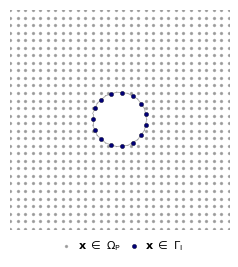

In [94]:
plot_field_over_domain(aVertex, aElement, aCenters, f, points_outside)

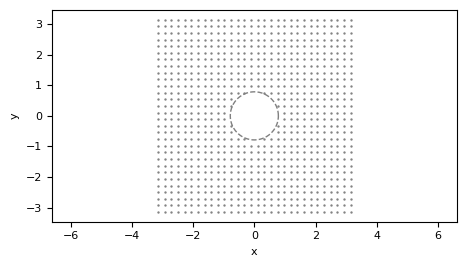

In [77]:
# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 30
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-np.pi, xmax=np.pi,
    ymin=-np.pi, ymax=np.pi,
    r_exclude=np.pi / 4
)

plt.figure(figsize=(4.5, 2.5))
plt.scatter(points_outside[:, 0], points_outside[:, 1], color='gray', s=0.5, label='Dominio')
#plt.scatter(points_inside[:, 0], points_inside[:, 1], color='red', s=5, label='Dentro del círculo')

# Dibujar el círculo excluido para referencia visual
theta = np.linspace(0, 2 * np.pi, 300)
r_exclude = (np.pi / 4)
x_circ = r_exclude * np.cos(theta)
y_circ = r_exclude * np.sin(theta)
plt.plot(x_circ, y_circ, '--', color='gray', label='Obstáculo', linewidth=1.0)

plt.axis('equal')
#plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
#plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.tight_layout()
plt.savefig("domain_points.svg", dpi=150, bbox_inches='tight')
plt.show()

In [114]:
# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 30
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-np.pi, xmax=np.pi,
    ymin=-np.pi, ymax=np.pi,
    r_exclude= (np.pi / 4)
)

# Inicializar el potencial incidente en los puntos exteriores como cero
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

In [115]:
c, density = None, None  # Se puede cambiar si se tienen valores iniciales
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

In [116]:
# Evaluar el potencial numérico en los puntos del dominio exterior
interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

In [117]:
r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]


# Interpolar datos en la grilla
grid_z = griddata(points_outside, interiorPhi, (X, Y), method='linear')
 
r_exclude=np.pi / 4
grid_z = np.ma.masked_where((X**2 + Y**2) < (r_exclude), grid_z)

u_scn_amp = grid_z.real
u_scn_phase = grid_z.imag

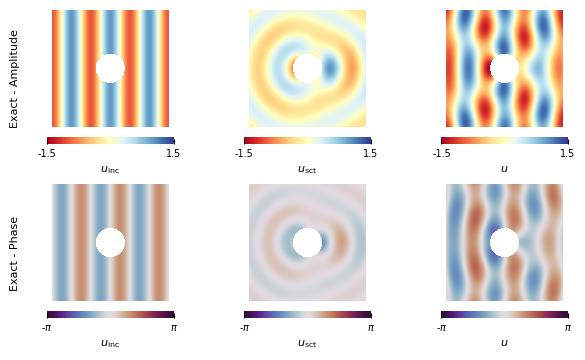

In [118]:
# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Plot the displacement amplitude
plot_exact_displacement(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

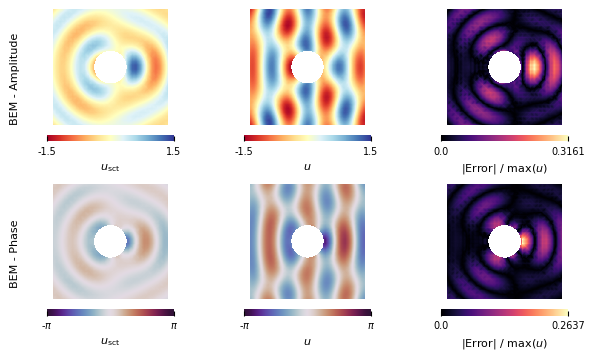

In [119]:
plot_bem_displacements(X, Y, u_scn_amp, np.real(u_inc_exact) + u_scn_amp, np.abs(np.real(u_scn_exact)-u_scn_amp), u_scn_phase, u_scn_phase+np.real(u_inc_exact), np.abs(np.imag(u_scn_exact)-u_scn_phase))

In [108]:
# Enmascar el potencial numérico en los puntos del dominio exterior
R_grid = np.sqrt(X**2 + Y**2)
# Crear una copia del arreglo original
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked = np.copy(u_scn_amp)


# Enmascarar los valores dentro del círculo de radio r_i
u_scn_exact_masked[R_grid < r_i] = 0
u_scn_amp_masked[R_grid < r_i] = 0
 
# Calcular el error relativo entre el potencial numérico y el exacto
relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2)/np.linalg.norm(u_scn_exact_masked.real, 2)
relative_error

np.float64(0.0908057042507733)

In [109]:
try:
    repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
    style = repo + "/styles/clean.mplstyle"
    plt.style.use(style)
except:
    pass

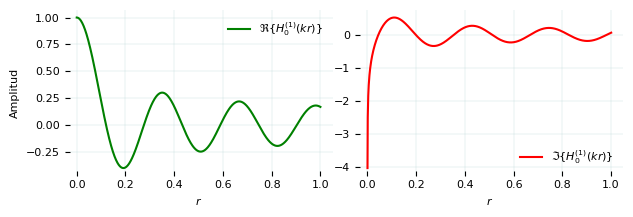

In [64]:
from scipy.special import hankel1
# Parámetros
k = 20.0
r = np.linspace(1e-4, 1.0, 1000)  # evitar r = 0 para evitar la singularidad infinita

# Evaluar la función de Hankel
H0 = hankel1(0, k * r)

# Graficar
plt.figure(figsize=(6, 2))

# Parte real
plt.subplot(1, 2, 1)
plt.plot(r, np.real(H0), label=r'$\Re\{H_0^{(1)}(kr)\}$',color='green')
#plt.title('Parte real de $H_0^{(1)}(kr)$')
plt.xlabel('$r$')
plt.ylabel('Amplitud')
#plt.grid(True)
plt.legend()

# Parte imaginaria
plt.subplot(1, 2, 2)
plt.plot(r, np.imag(H0), label=r'$\Im\{H_0^{(1)}(kr)\}$', color='red')
#plt.title('Parte imaginaria de $H_0^{(1)}(kr)$')
plt.xlabel('$r$')
#plt.ylabel('Amplitud')
#plt.grid(True)
plt.legend()

#plt.suptitle('Comportamiento de $H_0^{(1)}(kr)$ cerca de $r=0$ (singularidad logarítmica)', fontsize=14)
plt.tight_layout()
plt.savefig("hankel1_singularidad.svg", dpi=150, bbox_inches='tight')
plt.show()